<a href="https://colab.research.google.com/github/Pythonista7/deeply-learning/blob/main/4_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a transformer


In [1]:
import torch
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [3]:
torch.set_default_device(device.type)

## Multi Head Attention
Starting off with the core matter at hand, lets implemet attention block.
> Keys decide where to look, values decide what you take, queries decide who is asking.

In [4]:
# @title
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,heads = 6):
        super().__init__()
        self.d_model = d_model
        self.heads = heads

        if d_model % heads != 0:
          raise ValueError("d_model must be divisible by heads")

        self.d_head = d_model // heads

        # So its really of shape [d_model, H * d_head]
        # Think of each of these as H blocks concatenated horizontally
        # Like WQ​=[WQ(1)​∣WQ(2)​∣…∣WQ(H)​] where each WQ(i) is of shape [d_model,d_head] stacked H times.
        self.Q_linear_projection_layer = nn.Linear(self.d_model,self.d_model,device=device)
        self.K_linear_projection_layer = nn.Linear(self.d_model,self.d_model,device=device)
        self.V_linear_projection_layer = nn.Linear(self.d_model,self.d_model,device=device)

        self.softmax = nn.Softmax(dim = -1)
        self.W_o = nn.Linear(d_model,d_model,device=device)

    def forward(self,Q,K,V,mask=None,padding_mask=None):
      """
      We assumme to get matrices of dimensions [ B, T, d_model].
      We calculate based on number of heads the dimension of each head as d_head = d_model/H where  where H is the number of heads.
      We use additive mask, assumming the input mask to be containing [0 or 1], 1 to preserve and 0 to hide, this can be easily generated using torch.tril()


      Q = [B,T,d_model]
      K = [B,T,d_model]
      V = [B,T,d_model]
      mask = [T,T] # casual mask to hide future tokens,  (1 = show token, 0 = hide token)
      padding_mask = [B,T] # to hide padding tokens from attention,  (1 = real token, 0 = pad)
      """
      # Linear Projections
      q_linear_projections = self.Q_linear_projection_layer(Q)
      k_linear_projections = self.K_linear_projection_layer(K)
      v_linear_projections = self.V_linear_projection_layer(V)

      # Reshape output for heads
      # [B,T_q, H * d_head]
      B,T_q,D = q_linear_projections.shape
      q_linear_projections = q_linear_projections.reshape(B,T_q,self.heads,self.d_head).transpose(1,2) # [B,H,T,d_head]
      assert q_linear_projections.shape == (B,self.heads,T_q,self.d_head)

      B,T_k,D = k_linear_projections.shape
      k_linear_projections = k_linear_projections.reshape(B,T_k,self.heads,self.d_head).transpose(1,2) # [B,H,T,d_head]
      assert k_linear_projections.shape == (B,self.heads,T_k,self.d_head)

      B,T_k,D = v_linear_projections.shape
      v_linear_projections = v_linear_projections.reshape(B,T_k,self.heads,self.d_head).transpose(1,2) # [B,H,T,d_head]
      assert v_linear_projections.shape == (B,self.heads,T_k,self.d_head)

      # Scaled Attention = [B,H,T_q,d_head] * [B,H,d_head,T_k] -> [B,H,T_q,T_k]
      scores = (q_linear_projections @ k_linear_projections.transpose(-2,-1) ) / (q_linear_projections.shape[-1] ** 0.5)

      # note this might not work in case of cross attention we will need to specifically separate T_q and T_k , rn they are equal.
      assert scores.shape == (B,self.heads,T_q,T_k)

      if mask is not None:
        # Causual Attention Mask
        # Doing this will cause the softmax -> 0 where numbers are close to -inf hence masking them
        mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        scores = scores + mask

      # For starters , skip this for now and revisit when you reach "Padding" section for it to make more sense
      if padding_mask is not None:
        # Padding Mask to remove attention on pad tokens , (1 = real token, 0 = pad)
        # pad_mask dim [B,T] and scores is [B,H,T,T] -> we first conv the pad_mask from [B,T] to [B,1,1,T_k] and then mask the scores on the `T_k` (note T=T_k=T_q rn)
        # the reason we pad_mask on the T_k dim is to even avoid showing that the "keys" for padding token exist so that its never used for attn.
        scores = scores.masked_fill(padding_mask.unsqueeze(1).unsqueeze(2) == 0, float('-inf'))

      scores = self.softmax(scores)

      # This catches wrong softmax dim and mask weirdness instantly , basically tries to sum the dim on which softmax was applied and checks if its close to 1 which it should be.
      assert torch.allclose(scores.sum(dim=-1), torch.ones_like(scores.sum(dim=-1)), atol=1e-4, rtol=1e-4)

      # [B,H,T_q,T_k] @ [B,H,T_k,d_head] -> [B,H,T_q,d_head]
      scaled_attn_result = scores @ v_linear_projections

      # Concat , but this is really doing the reverse of what we did in the reshape previous to scaled attention.
      scaled_attn_result = scaled_attn_result.transpose(1,2).reshape(B,T_q,D)

      # Output Projection
      result = self.W_o(scaled_attn_result)
      return result


In [5]:
mha = MultiHeadAttention(840)

In [6]:
random_input = torch.rand((2,10,840))

In [7]:
res = mha.forward(random_input,random_input,random_input)

In [8]:
res.shape

torch.Size([2, 10, 840])

Now that we have a basic attention block setup lets focus on a couple other fundamental blocks required to piece together an Encoder and a Decoder! Next we will required 2 things : 1. an embedding layer and 2. positional encoder. `1.` tells the attention block "what" and `2.` convey's "where" in the sequence, both of which are crucial.

## Positional Encoding
We need to calculate a P.E value of dims [T,d_model] as per the paper and we do a add to the input embedding, broadcasting should automatically handle adding PE to batches since PE will be same across the batch for a given position.

$PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}} )$

$PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}} )$

where `pos` is the position and `i` is the dimension

Notice that the input angles to both sin and cos are the same. so lets generate that that first and then apply sin and cos alternatively across the range.

In [9]:
def get_positional_encoding(T,d_model):
  """
  T: sequence length
  d_model: model dimentions , also same as embedding dims
  """
  # Alot of things from this function can be precomputed ,stored and reused for better performance.
  i = torch.arange(0,d_model,2)
  # this is written as ^-1 so it can be multiplied insted of div
  div = torch.exp(-torch.log(torch.tensor(10000,device=device))*i/d_model).unsqueeze(0) # (1, d_model//2)
  pos = torch.arange(0,T,1,device=device).unsqueeze(1) # [T,1]
  # print(f"pos shape {pos.shape} , div shape {div.shape}")
  angles = pos * div
  positional_encodings = torch.zeros((T,d_model))
  positional_encodings[:,0::2] = torch.sin(angles)
  positional_encodings[:,1::2] = torch.cos(angles)
  return positional_encodings

In [10]:
test_pos_enc_data = torch.rand((10,840))
get_positional_encoding(10,840)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.2955e-01,  ...,  1.0000e+00,
          1.0222e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.2649e-01,  ...,  1.0000e+00,
          2.0443e-04,  1.0000e+00],
        ...,
        [ 6.5699e-01,  7.5390e-01,  5.3540e-01,  ...,  1.0000e+00,
          7.1552e-04,  1.0000e+00],
        [ 9.8936e-01, -1.4550e-01,  9.9962e-01,  ...,  1.0000e+00,
          8.1774e-04,  1.0000e+00],
        [ 4.1212e-01, -9.1113e-01,  5.8103e-01,  ...,  1.0000e+00,
          9.1995e-04,  1.0000e+00]], device='cuda:0')

Since a lot of data can be cache and reused instead of recomputing the positional encodings for each token, we can use `register_buffer` as a device aware cache to populate a tensor outside the computation graph to store such values.

In [11]:
class PositionalEncoder(nn.Module):
  def __init__(self, T, d_model , **kwargs) -> None:
    super().__init__( **kwargs)
    self.sequence_len = T
    self.d_model = d_model

    pe = self.get_positional_encoding(self.sequence_len,self.d_model)
    self.register_buffer('pos_enc',pe)


  def get_positional_encoding(self,T,d_model):
    """
    T: sequence length
    d_model: model dimentions , also same as embedding dims
    """
    # Alot of things from this function can be precomputed ,stored and reused for better performance.
    i = torch.arange(0,d_model,2)
    # this is written as ^-1 so it can be multiplied insted of div
    div = torch.exp(-torch.log(torch.tensor(10000,device=device))*i/d_model).unsqueeze(0) # (1, d_model//2)
    pos = torch.arange(0,T,1,device=device).unsqueeze(1) # [T,1]
    # print(f"pos shape {pos.shape} , div shape {div.shape}")
    angles = pos * div
    positional_encodings = torch.zeros((T,d_model))
    positional_encodings[:,0::2] = torch.sin(angles)
    positional_encodings[:,1::2] = torch.cos(angles)
    return positional_encodings

  def forward(self,X):
    input_seq_len = X.shape[1]
    assert input_seq_len <= self.sequence_len , f"Input sequence length {input_seq_len} is greater than positional encoder sequence length {self.sequence_len}"
    return X + self.pos_enc[:input_seq_len,:]

In [12]:
test_pos_enc_data = torch.rand((4,10,840))

In [13]:
test_pe = PositionalEncoder(10,840)
test_pe(test_pos_enc_data)

tensor([[[ 0.2865,  1.7899,  0.6031,  ...,  1.8389,  0.9199,  1.8234],
         [ 1.0716,  1.3771,  1.8260,  ...,  1.8238,  0.7456,  1.0055],
         [ 1.2211,  0.3448,  1.7209,  ...,  1.4377,  0.4788,  1.3676],
         ...,
         [ 1.2090,  1.0296,  0.6954,  ...,  1.5107,  0.3354,  1.6215],
         [ 1.6484,  0.8247,  1.6996,  ...,  1.9385,  0.8038,  1.3866],
         [ 1.2794, -0.0984,  1.3451,  ...,  1.8769,  0.3547,  1.3875]],

        [[ 0.5407,  1.1388,  0.3998,  ...,  1.8065,  0.7888,  1.4511],
         [ 1.4266,  1.1337,  1.0866,  ...,  1.2334,  0.6506,  1.1799],
         [ 1.4351, -0.0432,  1.1957,  ...,  1.2131,  0.5314,  1.4834],
         ...,
         [ 0.6801,  1.4490,  0.8586,  ...,  1.9971,  0.2125,  1.2243],
         [ 1.6119,  0.4914,  1.4652,  ...,  1.9268,  0.1581,  1.7075],
         [ 0.6636, -0.1364,  0.9700,  ...,  1.3094,  0.8309,  1.1877]],

        [[ 0.0969,  1.2311,  0.4138,  ...,  1.3008,  0.4648,  1.6343],
         [ 1.0057,  1.1297,  1.3888,  ...,  1

## Token Embedding
What this does is take the token input and convert it into representational embeddings encoding data per token incliding both "what the token is" with the embedding layer and also "where the token is" with the positional encoding.

In [14]:
class InputEmbedding(nn.Module):
  def __init__(self,vocab_size,d_model,max_seq_len = 1024):
    super().__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.embedding_layer = nn.Embedding(self.vocab_size,self.d_model)
    self.pos_encoder = PositionalEncoder(max_seq_len,self.d_model)

  def forward(self,X):
    """
    X: input vector of shape (batch_size,seq_len) with values in range [0,vocab_size]
    """
    input_embedding = self.embedding_layer(X) * torch.sqrt(torch.tensor(self.d_model,device=device)) # scaling this by sqrt(d_model) as suggested in the paper.
    pos_encoded_input = self.pos_encoder(input_embedding)
    return pos_encoded_input


In [15]:
# # A small test to see if this works
# B, T = 2, 5
# vocab_size = 100
# d_model = 32

# X = torch.randint(0, vocab_size, (B, T))   # must be long
# embed = InputEmbedding(vocab_size, d_model, max_seq_len=10)

# Y = embed(X)

# print("X:", X.shape, X.dtype)
# print("Y:", Y.shape, Y.dtype)


## Encoder


In [16]:
class Encoder(nn.Module):
  def __init__(self, d_model, vocab_size, no_of_heads,max_seq_len=1024):
    super().__init__()
    self.d_ff = 4 * d_model
    # The input embedding is going to be generated outside the Encoder since we want to "stack" up encoders
    # stack = feeding the output of one EncoderLayer into the next, repeatedly, with new learnable parameters each time.
    # The Input to the forward pass much be geneated from the layer InputEmbedding(d_model=d_model, vocab_size=vocab_size,max_seq_len=max_seq_len)

    self.MHA = MultiHeadAttention(d_model = d_model, heads = no_of_heads)
    self.norm1 = nn.LayerNorm(d_model)
    self.linear1 = nn.Linear(d_model,self.d_ff)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(self.d_ff,d_model)
    self.norm2 = nn.LayerNorm(d_model)

  def forward(self,X,padding_mask=None):
    # The input is going to be of dims [B,T,d_model]
    attn = self.MHA(Q=X,K=X,V=X,padding_mask=padding_mask)
    layer_norm1 = self.norm1(X + attn) # Note we also add the residual skip conn here
    feed_forward1 = self.linear1(layer_norm1)
    a1 = self.relu1(feed_forward1)
    feed_forward2 = self.linear2(a1)
    layer_norm2 = self.norm2(feed_forward2 + layer_norm1) # residual skip connection
    return layer_norm2

## Decoder


In [17]:
class Decoder(nn.Module):
  def __init__(self,d_model,no_of_heads) -> None:
    # Even here to allow "stack"ing of decoder we omit having the embeddings and the output probs within the class.
    # The `output_embedding` to the forward pass much be geneated from the layer InputEmbedding
    super().__init__()
    self.d_ff = 4 * d_model
    self.no_of_heads = no_of_heads
    self.d_model = d_model

    self.self_MHA = MultiHeadAttention(d_model = d_model, heads = no_of_heads)
    self.norm1 = nn.LayerNorm(d_model)
    self.cross_MHA = MultiHeadAttention(d_model = d_model, heads = no_of_heads)
    self.norm2 = nn.LayerNorm(d_model)
    self.linear1 = nn.Linear(d_model,self.d_ff)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(self.d_ff,d_model)
    self.norm3 = nn.LayerNorm(d_model)

  def forward(self, output_embedding, encoder_output , mask=None, self_attn_padding_mask=None, cross_attn_padding_mask=None):
    """
    output_embedding: [B,T_q,d_model]
    encoder_output: [B,T_k,d_model]
    mask: [T_q,T_k] - causal mask to hide future tokens
    self_attn_padding_mask: [B,T_q] - to hide padding tokens from encoder at positions where <pad> exists
    cross_attn_padding_mask: [B,T_k] - technically shape is [B,T_q] - used to hide padding tokens from decoder at positions where <pad> exists in the tgt_in from which output_embedding is generated.
    """
    # [B,T,d_model]
    self_attn = self.self_MHA(Q=output_embedding, K=output_embedding, V=output_embedding, mask=mask, padding_mask = self_attn_padding_mask)
    layer_norm1 = self.norm1(self_attn + output_embedding)

    cross_attn = self.cross_MHA(Q=layer_norm1, K=encoder_output, V=encoder_output, padding_mask = cross_attn_padding_mask)
    layer_norm2 = self.norm2(cross_attn + layer_norm1)

    feed_forward1 = self.linear1(layer_norm2)
    a1 = self.relu1(feed_forward1)
    feed_forward2 = self.linear2(a1)
    layer_norm3 = self.norm3(feed_forward2 + layer_norm2) # residual skip connection

    return layer_norm3


## Transformer Layer


In [18]:
class MyTransformer(torch.nn.Module):
  def __init__(self, N_encoder, N_decoder, d_model, vocab_size, no_of_heads, max_seq_len,pad_id = None) -> None:
    super().__init__()

    self.pad_id = pad_id
    self.N_encoder = N_encoder
    self.N_decoder = N_decoder

    self.d_model = d_model
    self.vocab_size = vocab_size
    self.no_of_heads = no_of_heads
    self.max_seq_len = max_seq_len

    self.encoders: torch.nn.ModuleList[Encoder] = torch.nn.ModuleList([Encoder(d_model=self.d_model, vocab_size=self.vocab_size, no_of_heads=self.no_of_heads) for e in range(N_encoder) ])
    self.decoders: torch.nn.ModuleList[Decoder] = torch.nn.ModuleList([Decoder(d_model=self.d_model, no_of_heads=self.no_of_heads) for d in range(N_decoder)] )

    self.encoder_embedding_layer = InputEmbedding(self.vocab_size,self.d_model,max_seq_len=self.max_seq_len)
    self.decoder_embedding_layer = InputEmbedding(self.vocab_size,self.d_model,max_seq_len=self.max_seq_len)

    # final decoded output projection + softmax
    # we will be converting [B,T,d_model] back into [B,T]
    self.final_linear = torch.nn.Linear(in_features=d_model,out_features=vocab_size)
    self.final_softmax = torch.nn.Softmax(dim=-1)

  def forward(self,X,tgt_in,is_training = False):
    # X.shape = [B, T]

    # Encoder Embedding
    input_embeddings = self.encoder_embedding_layer(X) # [B,T,d_model]

    z_e = input_embeddings
    enc_pad_mask = (X != self.pad_id)
    # pass through all the encoders
    for e in self.encoders:
      z_e = e(z_e, padding_mask = enc_pad_mask)

    # decoder embedding
    output_embeddings = self.decoder_embedding_layer(tgt_in)

    # pass through decoder units
    B_o,T_o,d_model = output_embeddings.shape

    # mask is applied to the self attention output which is of shape [B,T,T] which the mask should match
    mask = torch.tril(torch.ones(T_o,T_o,device=output_embeddings.device))
    dec_pad_mask = (tgt_in != self.pad_id)

    z_d = output_embeddings
    for d in self.decoders:
      z_d = d(output_embedding = z_d, encoder_output = z_e , mask = mask, self_attn_padding_mask = dec_pad_mask , cross_attn_padding_mask = enc_pad_mask )

    # final linear + softmax to get pred-token log-probs
    logits = self.final_linear(z_d) # [B,T,d_model] x [d_model,vocab_size] -> [B,T,vocab_size]

    if not is_training:
      with torch.no_grad():
        return self.final_softmax(logits[:,-1,:]) # apply it to the last token only which is basically the prediction.

    return logits # we need just logits for training to compare it for loss fn like cross-entropy

### ***Note on padding masks***
In attention you always have:
- Queries Q from some sequence (length T_q)
- Keys/Values K,V from some sequence (length T_k)

Scores are:
```latex
scores ∈ R \^{T_q x T_k}
```

Padding mask is used to hide columns (key positions), because columns correspond to which key token you're attending to. That's why it's called key padding mask.

So “key padding mask” always has shape [B, T_k] — it describes which positions in K/V are padding.


## Training Data ( Cesars Cipher )

Now that we have an encoder-decoder stack lets build a small learning task which should learn to decipher a simple cesar's cipher but of dynamic offset based on input. Lets consider only captial letters and some special tokens as part of the vocab.

### Vocab
- A-Z
- Special tokens: <BOS>,<EOS>
- Shift token: <S=0>...<S=25>

> **Note: in this case "token" means a character or one of the sepcial/shift tokens. Tokenization can happen differently based on the task.**


### How should a training example look like?
- The Encoder-Input should look something like this:
> `[<S=3>,D,E,F,<EOS>]`

- The Decoder-Input (`tgt_in`) should look something like this:
> `[<BOS>,A,B,C,<EOS>]`

- And the `tgt_out` (for training) for the decoder should be:
> `[A,B,C,<EOS>]`


So the decoder is trained to predict the next plaintext token given:
* the previous plaintext tokens (via masked self-attn), and
* the whole (shift + ciphertext) via cross-attn.

In [19]:
import string
import random
import regex as re
import pprint

### Establishing a VOCAB

In [20]:
# Special Tokens
start_token = '<BOS>'
end_token = '<EOS>'
pad_token = '<PAD>'
special_tokens = [pad_token,start_token,end_token]

In [21]:
# Offset tokens
offset_tokens = [f'<S={i}>' for i in range(26)]

In [22]:
USER_TOKENS = list(string.ascii_uppercase) + [" "]
VOCAB = special_tokens + offset_tokens + USER_TOKENS
stoi = {t:i for i,t in enumerate(VOCAB)} # string to int
itos = {i:t for t,i in stoi.items()} # int to string

pprint.pprint(' , '.join(VOCAB))
pprint.pprint(f"Vocab size: {len(VOCAB)}")
print(f"\nstoi: {stoi}")
print(f"\nitos: {itos}")

('<PAD> , <BOS> , <EOS> , <S=0> , <S=1> , <S=2> , <S=3> , <S=4> , <S=5> , '
 '<S=6> , <S=7> , <S=8> , <S=9> , <S=10> , <S=11> , <S=12> , <S=13> , <S=14> , '
 '<S=15> , <S=16> , <S=17> , <S=18> , <S=19> , <S=20> , <S=21> , <S=22> , '
 '<S=23> , <S=24> , <S=25> , A , B , C , D , E , F , G , H , I , J , K , L , M '
 ', N , O , P , Q , R , S , T , U , V , W , X , Y , Z ,  ')
'Vocab size: 56'

stoi: {'<PAD>': 0, '<BOS>': 1, '<EOS>': 2, '<S=0>': 3, '<S=1>': 4, '<S=2>': 5, '<S=3>': 6, '<S=4>': 7, '<S=5>': 8, '<S=6>': 9, '<S=7>': 10, '<S=8>': 11, '<S=9>': 12, '<S=10>': 13, '<S=11>': 14, '<S=12>': 15, '<S=13>': 16, '<S=14>': 17, '<S=15>': 18, '<S=16>': 19, '<S=17>': 20, '<S=18>': 21, '<S=19>': 22, '<S=20>': 23, '<S=21>': 24, '<S=22>': 25, '<S=23>': 26, '<S=24>': 27, '<S=25>': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y

In [23]:
# Utils
def encode_tokens(tokens):
    return [stoi[t] for t in tokens]

def decode_ids(ids):
    return "".join(itos[i] for i in ids)

### Simple Tokenizer

In [24]:
def tokenizer(text: str):
  tokens = []
  i = 0
  while i < len(text):
    if text[i] == '<':
      j = text.find('>',i)
      if j == -1:
        raise ValueError("Unclosed <...> token")
      if text[i:j+1] in VOCAB:
        token = text[i:j+1]
        i = j+1
      else:
        raise ValueError(f"Invalid token {text[i:j+1]}")
    else:
      token = text[i]
      i += 1

    tokens.append(token)

  return tokens

### Generating Data

In [25]:
def generate_random_string(size: int):
  # generate a rand string of given len
  return ''.join(random.choices(USER_TOKENS, k=size))

In [26]:
def offset_string(s: str, offset: int):
  # offsets each char of the input string s by `offset` chars, cycle back to A after Z
  result = []
  for char in s:
    if 'A' <= char <= 'Z':
      shifted_char_code = ord(char) + offset
      # Handle wrap-around for uppercase letters
      if shifted_char_code > ord('Z'):
        shifted_char_code = ord('A') + (shifted_char_code - ord('Z') - 1)
      elif shifted_char_code < ord('A'):
        shifted_char_code = ord('Z') - (ord('A') - shifted_char_code - 1)
      result.append(chr(shifted_char_code))
    else:
      result.append(char) # Keep non-alphabetic characters as they are
  return ''.join(result)

In [27]:
def generate_cipher_pair(max_len: int = 30,max_offset=20):

  s = generate_random_string(random.randint(1,max_len))
  offset = random.randint(0,max_offset)
  cipher = offset_string(s,offset)

  cipher_text = f"<S={offset}>{cipher}{end_token}"
  deciphered_text = f"{start_token}{s}{end_token}"

  return (cipher_text,deciphered_text)

In [28]:
def generate_triplet_from_pair(pair):
  C,P = pair
  enc_in = tokenizer(C)

  tokenized_P = tokenizer(P)

  dec_in = tokenized_P[:-1]
  tgt_out = tokenized_P[1:]

  return (encode_tokens(enc_in),encode_tokens(dec_in),encode_tokens(tgt_out))

In [29]:
generate_sample = lambda max_len,max_offset: generate_triplet_from_pair(generate_cipher_pair(max_len,max_offset))

In [30]:
def generate_training_data(training_count: int,test_count: int, max_len: int = 30, max_offset:int = 20,testing_offset:int = 10):
  train = []
  for i in range(training_count):
    train.append(
        generate_sample(max_len,max_offset)
      )

  # Lets make some changes in the test like increasing max_len,max_offset to see if the model truly learns it or is just overfitting
  test = []
  for i in range(test_count):
    test.append(
        generate_sample(max_len,max_offset)
      )

  return {"train":train,"test":test}

run the below cell without calling encode_tokens() in th above block to see data in text form.

In [31]:
# @title
rand_data = generate_training_data(2,2,5,5,0)
pprint.pprint(rand_data)

{'test': [([7, 46, 29, 29, 33, 38, 2],
           [1, 42, 51, 51, 29, 34],
           [42, 51, 51, 29, 34, 2]),
          ([3, 52, 49, 50, 45, 45, 2],
           [1, 52, 49, 50, 45, 45],
           [52, 49, 50, 45, 45, 2])],
 'train': [([4, 32, 54, 31, 2], [1, 31, 53, 30], [31, 53, 30, 2]),
           ([4, 31, 34, 39, 2], [1, 30, 33, 38], [30, 33, 38, 2])]}


## Inspecting dims w.r.t the model

Notice how each sample can be of a varied length and even our transformer has a independant dimension for input sequence , but the problem comes when we wish to batch these sequences together. We will be forced to only batch sequences of same length togerther in the current implementation which is not nice! To solve this issue we will introduce "padding" which will make all sequences have the same length without modifying their representation.

## Padding
Padding is not data.
Its a fake token whose only job is “make tensors rectangular”.

If attention treats `<PAD>` like a real token → model learns garbage correlations.

So padding must be invisible to attention.

Thats what padding masks do.


This must not be confused with the causual mask we use to hide "future" tokens in the decoder.self_attention, that is to prevent the model from cheating by peeking into the future , this padding is to completely ignore the token from being atteneded to all together.


It is important to fully ignore padding because if we do endup including them then it would mean that `<PAD>` token is somehow useful to the sequence and the actually string should attended to `<PAD>` and wise versa which is wrong and not what is intended.

To do this, im going back and including this `"padding_mask"` in our encoder and decoder.

***Also note that pad tokens must also be ignored when calculating loss!***

In [32]:
def pad_1d(seq, max_len, pad_value):
    return seq + [pad_value] * (max_len - len(seq))

def collate(batch, pad_value, device="cpu"):
  """
  batch: list[(src_ids, tgt_in_ids, tgt_out_ids)]
  pad_value: int - pad_id as per the vocab used
  """
  # batch: list[(src_ids, tgt_in_ids, tgt_out_ids)]
  srcs, tgts_in, tgts_out = zip(*batch)

  max_src = max(len(s) for s in srcs)
  max_tgt = max(len(t) for t in tgts_in)  # tgt_in and tgt_out are same length

  src_batch = torch.tensor([pad_1d(s, max_src, pad_value) for s in srcs], dtype=torch.long, device=device)
  tin_batch = torch.tensor([pad_1d(t, max_tgt, pad_value) for t in tgts_in], dtype=torch.long, device=device)
  tout_batch= torch.tensor([pad_1d(t, max_tgt, pad_value) for t in tgts_out], dtype=torch.long, device=device)

  return src_batch, tin_batch, tout_batch

## Create the Transformer Model

In [33]:
model = MyTransformer(
    N_encoder = 3,
    N_decoder = 3,
    d_model = 512,
    vocab_size = len(VOCAB),
    no_of_heads= 8,
    max_seq_len= 128,
    pad_id = stoi[pad_token]
)

## Train'in Time!

In [34]:
import torch.nn.functional as F

In [35]:

def train_step(model, opt, src_ids, tgt_in_ids, tgt_out_ids,pad_id):
  model.train()
  opt.zero_grad(set_to_none=True)

  logits = model(src_ids, tgt_in_ids, is_training=True)  # [B, T, V]
  loss = F.cross_entropy(
      logits.reshape(-1, logits.size(-1)),
      tgt_out_ids.reshape(-1),
      ignore_index=pad_id
  )
  loss.backward()
  opt.step()
  return float(loss.item())

In [36]:
# !pip uninstall sympy -y

In [37]:
# !pip install sympy

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)

def sample_batch(batch_size, max_len=30, max_offset=20):
    return [generate_sample(max_len, max_offset) for _ in range(batch_size)]

Just acknowlading here that generating datasets on the fly especially with randomness involed is probably not a good idea, but going ahead anyway since this is just a toy example.

In [40]:
for step in range(5000):
  batch = sample_batch(batch_size=64, max_len=30, max_offset=20)
  src_ids, tgt_in_ids, tgt_out_ids = collate(batch,pad_value=stoi[pad_token], device=device)
  loss = train_step(model, opt, src_ids, tgt_in_ids, tgt_out_ids,stoi[pad_token])

  if step % 100 == 0:
      print(f"step={step} loss={loss:.4f}")

step=0 loss=3.2185
step=100 loss=3.1829
step=200 loss=3.4455
step=300 loss=3.1861
step=400 loss=3.1538
step=500 loss=3.1460
step=600 loss=3.1589
step=700 loss=3.0158
step=800 loss=2.9698
step=900 loss=2.9241
step=1000 loss=2.8403
step=1100 loss=2.7832
step=1200 loss=2.7214
step=1300 loss=2.7144
step=1400 loss=2.7902
step=1500 loss=2.7270
step=1600 loss=2.7555
step=1700 loss=2.5880
step=1800 loss=2.5297
step=1900 loss=2.4549
step=2000 loss=2.6077
step=2100 loss=2.5214
step=2200 loss=2.5672
step=2300 loss=2.5490
step=2400 loss=2.5362
step=2500 loss=2.5401
step=2600 loss=2.5238
step=2700 loss=2.5411
step=2800 loss=2.5217
step=2900 loss=2.4150
step=3000 loss=2.3901
step=3100 loss=2.2561
step=3200 loss=2.3457
step=3300 loss=2.4285
step=3400 loss=2.4289
step=3500 loss=2.3491
step=3600 loss=2.4564
step=3700 loss=2.3004
step=3800 loss=2.3234
step=3900 loss=2.3926
step=4000 loss=2.2739
step=4100 loss=2.2739
step=4200 loss=2.1803
step=4300 loss=2.2984
step=4400 loss=2.2056
step=4500 loss=2.2710


In [41]:
@torch.no_grad()
def greedy_decode(model, src_ids, max_steps=64):
  model.eval()
  B = src_ids.size(0)
  dec = torch.full((B, 1), stoi[start_token], dtype=torch.long, device=src_ids.device)

  for _ in range(max_steps):
      logits = model(src_ids, dec, is_training=False)   # if your is_training=False returns next-token probs only,
                                                        # then modify this to always return logits [B,T,V].
      # If is_training=False returns only last-step probs [B,V], do:
      if logits.dim() == 2:
          next_id = logits.argmax(dim=-1, keepdim=True)
      else:
          next_id = logits[:, -1, :].argmax(dim=-1, keepdim=True)

      dec = torch.cat([dec, next_id], dim=1)
      if (next_id == stoi[end_token]).all():
          break
  return dec

In [61]:
@torch.no_grad()
def show_one(model, max_len=20, max_offset=20):
  src, tgt_in, tgt_out = generate_sample(max_len, max_offset)
  src_ids, tgt_in_ids, tgt_out_ids = collate([(src, tgt_in, tgt_out)],pad_value=stoi[pad_token], device=device)

  pred_ids = greedy_decode(model, src_ids, max_steps=tgt_out_ids.size(1) + 5)[0].tolist()

  # Strip BOS and everything after EOS
  def strip(seq):
      out = []
      for x in seq:
          if x == stoi[end_token]: break
          out.append(x)
      return out

  src_str = decode_ids(src_ids[0].tolist())
  gold_str = decode_ids(strip(tgt_out_ids[0].tolist()))
  pred_str = decode_ids(strip(pred_ids[1:]))  # skip BOS

  # print("SRC :", src_str)
  # print("EXPT:", gold_str)
  # print("PRED:", pred_str)

  return src_str, gold_str, pred_str

In [60]:
show_one(model,max_len=5,max_offset=5)

SRC : <S=4>FEJWJ<EOS>
GOLD: BAFSF
PRED: FSFBA


## Define Accuracy Metric

Creating a Python function to calculate character-wise accuracy between the gold (expected) string and the predicted string. This function will be used to quantify the model's performance for each sample.


In [62]:
def calculate_accuracy(gold_str: str, pred_str: str) -> float:
  """
  Calculates character-wise accuracy between a gold string and a predicted string.

  Args:
    gold_str: The expected correct string.
    pred_str: The model's predicted string.

  Returns:
    The character-wise accuracy as a float.
  """
  if not gold_str:
    return 1.0 if not pred_str else 0.0 # If gold is empty, return 1.0 if pred is also empty, else 0.0

  match_count = 0
  min_len = min(len(gold_str), len(pred_str))

  for i in range(min_len):
    if gold_str[i] == pred_str[i]:
      match_count += 1

  return match_count / len(gold_str)

# Test cases
print(f"Accuracy ('ABC', 'ABC'): {calculate_accuracy('ABC', 'ABC')}") # Expected: 1.0
print(f"Accuracy ('ABC', 'ABD'): {calculate_accuracy('ABC', 'ABD')}") # Expected: 0.666...
print(f"Accuracy ('ABC', 'AB'): {calculate_accuracy('ABC', 'AB')}")   # Expected: 0.666...
print(f"Accuracy ('ABC', 'ABCD'): {calculate_accuracy('ABC', 'ABCD')}") # Expected: 1.0
print(f"Accuracy ('', ''): {calculate_accuracy('', '')}")             # Expected: 1.0
print(f"Accuracy ('A', ''): {calculate_accuracy('A', '')}")             # Expected: 0.0

Accuracy ('ABC', 'ABC'): 1.0
Accuracy ('ABC', 'ABD'): 0.6666666666666666
Accuracy ('ABC', 'AB'): 0.6666666666666666
Accuracy ('ABC', 'ABCD'): 1.0
Accuracy ('', ''): 1.0
Accuracy ('A', ''): 0.0


## Evaluate Model Performance

### Subtask:
Develop a loop that iterates through 'max_len' and 'max_offset' values from 1 to 25. For each combination, generate a specified number of samples (e.g., 5-10) using `generate_sample` and `greedy_decode`, calculate the average character accuracy using the previously defined function, and store the results along with the corresponding 'max_len' and 'max_offset' values.


**Reasoning**:
To evaluate the model comprehensively, I will iterate through different `max_len` and `max_offset` values, generate multiple samples for each combination, calculate the character-wise accuracy, and store the average accuracy. This will allow for visualizing the model's performance across various input complexities.



In [63]:
import numpy as np

# Initialize a list to store results
accuracy_results = []

# Define the range for max_len and max_offset
MAX_RANGE = 25
NUM_SAMPLES_PER_COMBINATION = 10

print(f"Starting model evaluation for max_len and max_offset from 1 to {MAX_RANGE}...")

for current_max_len in range(1, MAX_RANGE + 1):
    for current_max_offset in range(1, MAX_RANGE + 1):
        sample_accuracies = []
        for _ in range(NUM_SAMPLES_PER_COMBINATION):
            # show_one returns src_str, gold_str, pred_str
            _, gold_str, pred_str = show_one(model, max_len=current_max_len, max_offset=current_max_offset)
            accuracy = calculate_accuracy(gold_str, pred_str)
            sample_accuracies.append(accuracy)

        avg_accuracy = np.mean(sample_accuracies)
        accuracy_results.append({
            'max_len': current_max_len,
            'max_offset': current_max_offset,
            'average_accuracy': avg_accuracy
        })
        print(f"Evaluated (max_len={current_max_len}, max_offset={current_max_offset}): Avg Accuracy = {avg_accuracy:.4f}")

print("Evaluation complete. First 5 results:")
for i in range(min(5, len(accuracy_results))):
    print(accuracy_results[i])


Streaming output truncated to the last 5000 lines.
EXPT: FHGJOQ
PRED: FHJGP
Evaluated (max_len=19, max_offset=14): Avg Accuracy = 0.1060
SRC : <S=8>QZGXLF<EOS>
EXPT: IRYPDX
PRED: YQDXIQ
SRC : <S=15>AEM<EOS>
EXPT: LPX
PRED: PLX
SRC : <S=15>WCYZRPQXZV<EOS>
EXPT: HNJKCABIKG
PRED: KHBJNHBJC
SRC : <S=6>AHPXS<EOS>
EXPT: UBJRM
PRED: JBURM
SRC : <S=11>JGGP<EOS>
EXPT: YVVE
PRED: VEYV
SRC : <S=11>SUNXUCIOYKCJROPIDFC<EOS>
EXPT: HJCMJRXDNZRYGDEXSUR
PRED: RYDRDYHRMJDXUNHDSX
SRC : <S=5>JDYBYYPXT<EOS>
EXPT: EYTWTTKSO
PRED: TTEYOSKUX
SRC : <S=4>KGOFYGFSZIDNTJYQN<EOS>
EXPT: GCKBUCBOVEZJPFUMJ
PRED: VJOUBDKAFCVJDOGQ
SRC : <S=2>PVKOLNXPPJEUG<EOS>
EXPT: NTIMJLVNNHCSE
PRED: NNJMUITDMIFO
SRC : <S=6>ZPUNOZUWUGORQ<EOS>
EXPT: TJOHITOQOAILK
PRED: JPITOIALPTLI
Evaluated (max_len=19, max_offset=15): Avg Accuracy = 0.1410
SRC : <S=16>UQYMSEFMVUFHEEKCFI<EOS>
EXPT: EAIWCOPWFEPROOUMPS
PRED: OOOOOWERPVSEHBLDWQ
SRC : <S=5>K<EOS>
EXPT: F
PRED: F
SRC : <S=15>JTXDDRUAVIIMQOLYU<EOS>
EXPT: UEIOOCFLGTTXBZWJF
PRED: OTFJFBTXUOH

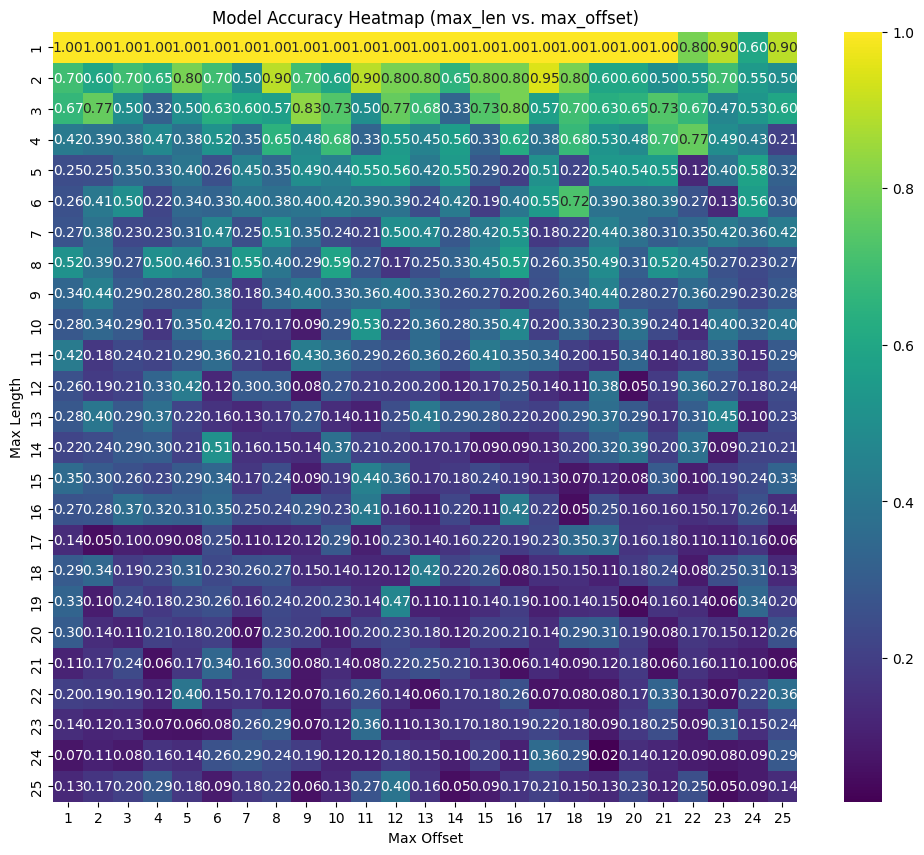

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for heatmap
heatmap_data = np.zeros((MAX_RANGE, MAX_RANGE))

for result in accuracy_results:
    row = result['max_len'] - 1
    col = result['max_offset'] - 1
    heatmap_data[row, col] = result['average_accuracy']

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=range(1, MAX_RANGE + 1),
    yticklabels=range(1, MAX_RANGE + 1)
)
plt.title('Model Accuracy Heatmap (max_len vs. max_offset)')
plt.xlabel('Max Offset')
plt.ylabel('Max Length')
plt.show()


### Model Performance Summary

**Overall Performance**: The heatmap shows a general trend where the model achieves high accuracy (close to 1.0) for shorter sequence lengths (`max_len`) and smaller offsets (`max_offset`). As either `max_len` or `max_offset` increases, the average accuracy tends to decrease significantly.

**Impact of Max Length**: The model performs very well when `max_len` is small (e.g., 1 or 2), often achieving 100% accuracy, regardless of the offset. As `max_len` increases, the model's ability to maintain high accuracy diminishes. For lengths beyond approximately 5-7, the accuracy drops considerably across most offset values.

**Impact of Max Offset**: Similarly, the model generally struggles with larger `max_offset` values. Even for short `max_len`, accuracy starts to dip when `max_offset` becomes large (e.g., above 20-22). For longer sequences, the effect of `max_offset` is more pronounced, with higher offsets leading to lower accuracy.

**Combined Effect**: The darkest regions (highest accuracy) are concentrated in the top-left corner of the heatmap, corresponding to low `max_len` and low `max_offset`. The accuracy quickly degrades as we move towards the bottom-right corner (higher `max_len` and higher `max_offset`). This suggests that the model primarily learned to decode short, simple ciphertexts and struggles to generalize to more complex or longer inputs, which could indicate a need for more extensive training, hyperparameter tuning, or architectural improvements if higher accuracies are desired for more challenging scenarios.